# Predict Delta Experiment

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/Users/tommylees/github/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

data_dir = Path('data/')
# data_dir = Path('/Volumes/Lees_Extend/data/zip_data')
data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data/')

assert data_dir.exists()

In [3]:
import seaborn as sns
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data

# Read in the data

In [4]:
X_train, y_train = read_train_data(data_dir)
X_test, y_test = read_test_data(data_dir)

In [5]:
ds = xr.merge([y_train, y_test]).sortby('time').sortby('lat')
d_ = xr.merge([X_train, X_test]).sortby('time').sortby('lat')
ds = xr.merge([ds, d_])

In [6]:
from src.utils import get_ds_mask
mask = get_ds_mask(X_train.VCI)

In [10]:
[d.name for d in (data_dir / 'models' / 'one_month_forecast_predict_delta').iterdir()]

['ealstm', 'linear_network', 'rnn']

In [48]:
# Standard Experiments
bline_pred = read_pred_data('previous_month', data_dir)[-1].where(~mask)
orig_ln_pred = read_pred_data('linear_network', data_dir,)[-1].where(~mask)
orig_rnn_pred = read_pred_data('rnn', data_dir,)[-1].where(~mask)
orig_ealstm_pred = read_pred_data('ealstm', data_dir)[-1].where(~mask)

# Predict Delta Experiments 
ln_pred = read_pred_data('linear_network', data_dir, experiment='one_month_forecast_predict_delta')[-1].where(~mask)
ealstm_pred = read_pred_data('ealstm', data_dir, experiment='one_month_forecast_predict_delta')[-1].where(~mask)

# ealstm_pred = read_pred_data('ealstm', data_dir)

## Explore how perform in each month

In [13]:
from src.analysis import annual_scores

In [23]:
print((data_dir / 'models/one_month_forecast_predict_delta/rnn/').exists())
[d.name for d in (data_dir / 'models/one_month_forecast_predict_delta/rnn/').iterdir()]

True


[]

In [46]:
# load the monthly scores dictionary
experiment = 'one_month_forecast_predict_delta'
monthly_scores = annual_scores(
    data_path=data_dir,
    models=['linear_network', 'ealstm'],
    metrics=['rmse', 'r2'],
    pred_years=[y for y in range(2011, 2019)],
    experiment=experiment,
    true_data_experiment='one_month_forecast',
    target_var='VCI',
    verbose=False,
    to_dataframe=True
)
monthly_scores['time'] = monthly_scores.apply(lambda row: pd.to_datetime(f"{int(row.month)}-{int(row.year)}"), axis=1)

monthly_scores2 = annual_scores(
    data_path=data_dir,
    models=['linear_network', 'ealstm', 'rnn', 'previous_month'],
    metrics=['rmse', 'r2'],
    pred_years=[y for y in range(2011, 2019)],
    experiment='one_month_forecast',
    true_data_experiment='one_month_forecast',
    target_var='VCI',
    verbose=False,
    to_dataframe=True
)
monthly_scores2['time'] = monthly_scores.apply(lambda row: pd.to_datetime(f"{int(row.month)}-{int(row.year)}"), axis=1)

# rename columns and to merge dataframes
monthly_scores2 = monthly_scores2.join(
    monthly_scores2[['linear_network', 'ealstm', 'rnn']].add_prefix('orig_')
).drop(columns=['linear_network', 'ealstm', 'rnn'])

# merge
monthly_scores = pd.merge(monthly_scores, monthly_scores2)
monthly_scores.head()

,ealstm,linear_network,month,year,metric,time,previous_month,orig_linear_network,orig_ealstm,orig_rnn
0,9.518235,20.316086,1.0,2011.0,rmse,2011-01-01,9.79577,22.490418,13.402106,11.853916
1,9.518235,20.316086,1.0,2011.0,rmse,2011-01-01,9.79577,-0.354995,0.518841,0.623585
2,9.518235,20.316086,1.0,2011.0,rmse,2011-01-01,9.79577,22.490418,13.402106,11.853916
3,9.518235,20.316086,1.0,2011.0,rmse,2011-01-01,9.79577,-0.354995,0.518841,0.623585
4,9.518235,20.316086,1.0,2011.0,rmse,2011-01-01,9.79577,22.490418,13.402106,11.853916


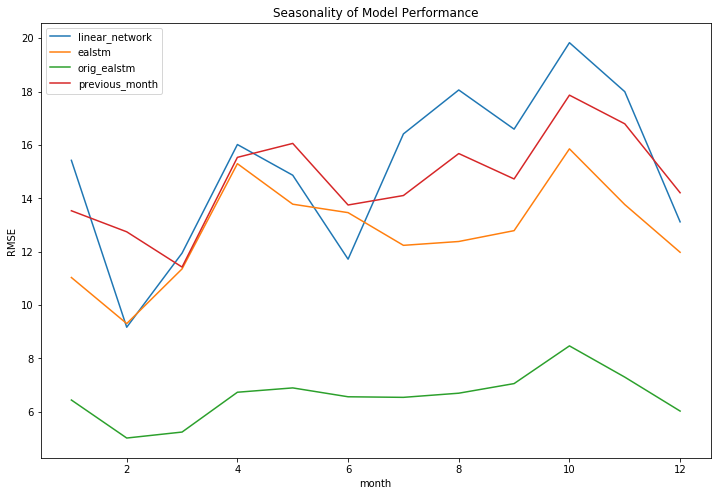

In [47]:
fig, ax = plt.subplots(figsize=(12, 8))
for model in ['linear_network', 'ealstm', 'orig_ealstm', 'previous_month']: # 
    (
        monthly_scores
        .where(monthly_scores.metric == 'rmse')
        .groupby('month').mean().reset_index()
        .plot(x='month', y=model, label=model, ax=ax)
    )
plt.legend()
ax.set_title('Seasonality of Model Performance')
ax.set_ylabel('RMSE');

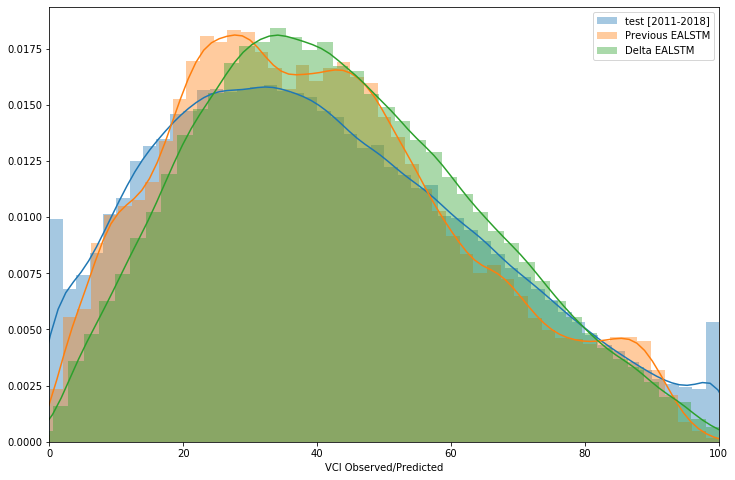

In [50]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(drop_nans_and_flatten(y_test.VCI), ax=ax, label='test [2011-2018]')
# sns.distplot(drop_nans_and_flatten(y_train.VCI), ax=ax, label='train [1982-2010]')
sns.distplot(drop_nans_and_flatten(orig_ealstm_pred), ax=ax, label='Previous EALSTM')
sns.distplot(drop_nans_and_flatten(ealstm_pred), ax=ax, label='Delta EALSTM')

ax.set_xlim([0, 100])
plt.legend()
ax.set_xlabel('VCI Observed/Predicted');

# Model Performance Comparisons

In [52]:
from src.analysis import spatial_rmse, spatial_r2
%autoreload 2

In [53]:
ealstm_rmse = spatial_rmse(
    y_test.VCI.transpose("time", "lat", "lon"), 
    ealstm_pred.transpose("time", "lat", "lon")
)

# --------
bline_rmse = spatial_rmse(
    y_test.VCI.transpose("time", "lat", "lon"), 
    bline_pred.transpose("time", "lat", "lon")
)

# --------
ealstm_base_rmse = spatial_rmse(
    y_test.VCI.transpose("time", "lat", "lon"), 
    orig_ealstm_pred.transpose("time", "lat", "lon")
)


# calculate mean performance scores
ealstm_mean = ealstm_rmse.mean().values
bline_mean = bline_rmse.mean().values
ealstm_base_mean = ealstm_base_rmse.mean().values

In [54]:
rmses = [bline_rmse, ealstm_rmse, ealstm_base_rmse]
means = [bline_mean, ealstm_mean, ealstm_base_mean]
labels = ['Basline', 'EALSTM', 'Original EALSTM']

colors = sns.color_palette()[:len(means)]

assert (len(rmses) == len(means)) &  (len(labels) == len(colors))
assert (len(rmses) == len(labels))

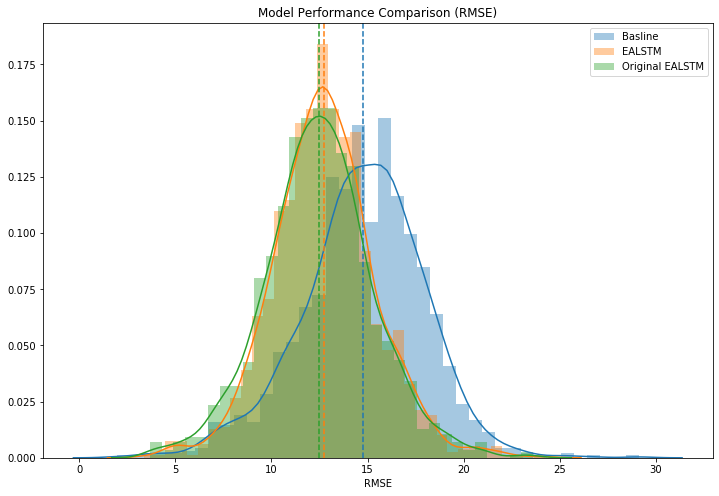

In [55]:
fig, ax = plt.subplots(figsize=(12, 8))

for i in range(len(rmses)):
    rmse = rmses[i]
    mean = means[i]
    label = labels[i]
    color = colors[i]
    sns.distplot(
        drop_nans_and_flatten(rmse), ax=ax,
        label=label, color=color
    )
    ax.axvline(mean, ls='--', color=color) # , label=f'{label}_mean'

plt.legend()
ax.set_xlabel('RMSE');
ax.set_title('Model Performance Comparison (RMSE)');
# ax.set_ylabel('Density')

Baseline EALSTM RMSE:  12.48606477255771
Best performing EALSTM RMSE:  12.754261017040395


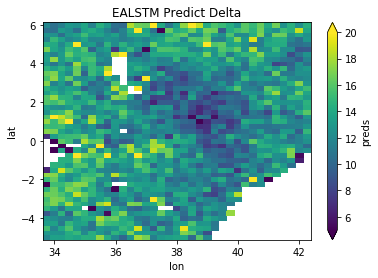

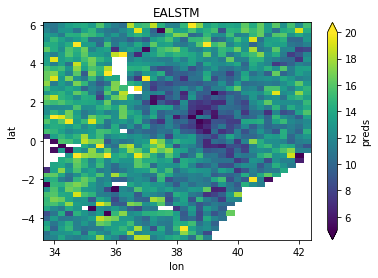

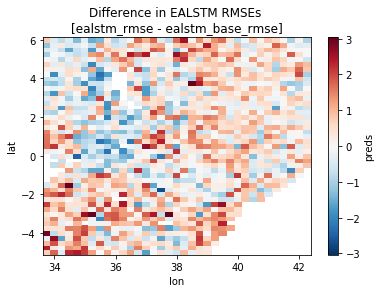

In [61]:
fig, ax = plt.subplots()
ealstm_rmse.plot(vmin=5, vmax=20, ax=ax)
ax.set_title('EALSTM Predict Delta')

fig, ax = plt.subplots()
ealstm_base_rmse.plot(vmin=5, vmax=20, ax=ax)
ax.set_title('EALSTM')

fig, ax = plt.subplots()
(ealstm_rmse - ealstm_base_rmse).plot(ax=ax)
ax.set_title('Difference in EALSTM RMSEs \n[ealstm_rmse - ealstm_base_rmse]')


print("Baseline EALSTM RMSE: ", ealstm_base_rmse.mean().values)
print("Best performing EALSTM RMSE: ", ealstm_rmse.mean().values)

# Regional Analysis

In [70]:
%autoreload 2
from src.analysis.region_analysis import RegionGeoPlotter, AdministrativeRegionAnalysis
warnings.filterwarnings('ignore')

analyzer = AdministrativeRegionAnalysis(
    data_dir=data_dir, experiment='one_month_forecast', 
    models_experiment_dir='one_month_forecast_predict_delta'
)

r = RegionGeoPlotter(data_dir)

Initialised the Region Analysis for experiment: one_month_forecast
Models: ['ealstm', 'linear_network', 'rnn']
Regions: ['district_l2_kenya.nc']
Region Type: administrative_boundaries
GroupbyRegion requires geopandas to be installed


In [71]:
region_path = analyzer.region_data_paths[0]
admin_level_name = region_path.name.replace('.nc', '')
region_da, region_lookup, region_group_name = analyzer.load_region_data(region_path)
valid_region_ids = [k for k in region_lookup.keys()]

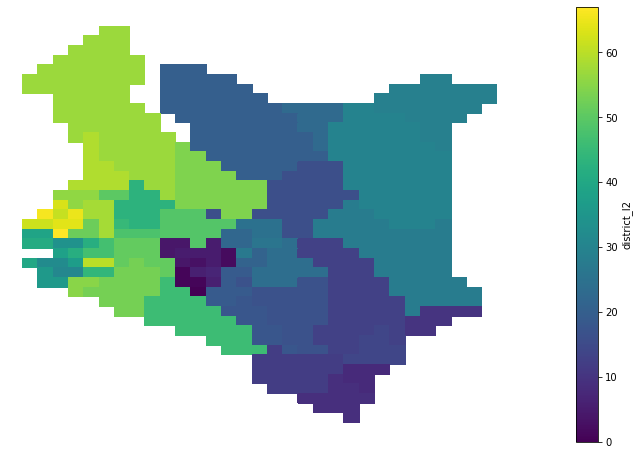

In [72]:
fig, ax = plt.subplots(figsize=(12, 8))
region_da.plot(ax=ax)
ax.set_axis_off()

# region_da.where(region_da == dict(zip(region_lookup.values(), region_lookup.keys()))['NAIROBI'])

In [73]:
def get_region_mask(region: str):
    lookup = dict(zip(region_lookup.values(), region_lookup.keys()))
    region_id = lookup[region]
    
    return ~region_da.where(region_da == region_id).isnull()

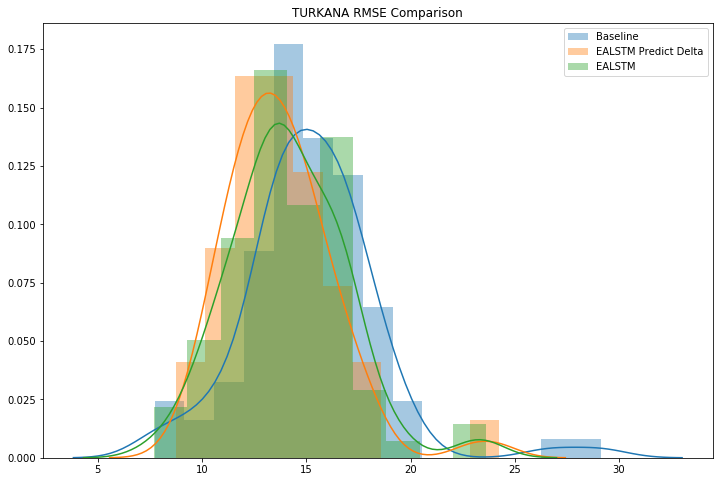

In [76]:
fig, ax = plt.subplots(figsize=(12, 8))

region = 'TURKANA'
msk = get_region_mask(region)
sns.distplot(drop_nans_and_flatten(bline_rmse.where(msk)), label='Baseline')
sns.distplot(drop_nans_and_flatten(ealstm_rmse.where(msk)), label='EALSTM Predict Delta')
sns.distplot(drop_nans_and_flatten(ealstm_base_rmse.where(msk)), label='EALSTM')
ax.set_title(f'{region} RMSE Comparison')
plt.legend();

### Make region dataframe

In [77]:
from src.analysis import AdministrativeRegionAnalysis
# analyzer = AdministrativeRegionAnalysis(data_dir=data_dir)

In [78]:
import pickle
warnings.filterwarnings('ignore')

if (data_dir / 'analysis/admin_region_analyzer_predict_delta.pkl').exists():
    analyzer = pickle.load(open(data_dir / 'analysis/admin_region_analyzer_predict_delta.pkl', 'rb'))
else:
    analyzer = AdministrativeRegionAnalysis(
        data_dir=data_dir, experiment='one_month_forecast', 
        models_experiment_dir='one_month_forecast_predict_delta'
    )
    analyzer.analyze()
    
    with open(data_dir / 'analysis/admin_region_analyzer_predict_delta.pkl', 'wb') as f:
        pickle.dump(analyzer, f)

Initialised the Region Analysis for experiment: one_month_forecast
Models: ['ealstm', 'linear_network', 'rnn']
Regions: ['district_l2_kenya.nc']
Region Type: administrative_boundaries
* Analyzing for district_l2_kenya *

** Analyzing for ealstm-district_l2_kenya **
** Written ealstm csv to /Volumes/Lees_Extend/data/ecmwf_sowc/data/analysis/region_analysis/ealstm/ealstm_district_l2_kenya.csv **

** Analyzing for linear_network-district_l2_kenya **
** Written linear_network csv to /Volumes/Lees_Extend/data/ecmwf_sowc/data/analysis/region_analysis/linear_network/linear_network_district_l2_kenya.csv **

** Analyzing for rnn-district_l2_kenya **
No matching time data found for rnn
Contents of rnn dir:
	[]
* Assigned all region dfs to `self.df` *

* Assigned Global Error Metrics to `self.global_mean_metrics` *
* Written csv to data/analysis/region_analysis/global_error_metrics_one_month_forecast_admin.csv *

* Assigned Regional Error Metrics to `self.regional_mean_metrics` *
* Written csv to

PicklingError: Can't pickle <class 'src.analysis.region_analysis.administrative_region_analysis.AdministrativeRegionAnalysis'>: it's not the same object as src.analysis.region_analysis.administrative_region_analysis.AdministrativeRegionAnalysis

In [79]:
region_plotter = analyzer.create_model_performance_by_region_geodataframe()
df = analyzer.df
gdf = region_plotter.gdf

The RegionGeoPlotter requires `geopandas` to be installed.
GroupbyRegion requires geopandas to be installed
Reading file: KEN_admin2_2002_DEPHA.shp
Reading file: Ken_Districts.shp
Reading file: Ken_Divisions.shp
Reading file: Kenya wards.shp
Reading file: Ken_Locations.shp
Reading file: Ken_Sublocations.shp
* Read shapefiles and stored in `RegionGeoPlotter.region_gdfs` *
* Assigned the complete GeoDataFrame to `RegionGeoPlotter.gdf`


In [89]:
orig_analyzer = pickle.load(open(data_dir / 'analysis/admin_region_analyzer_BEST.pkl', 'rb'))

orig_region_plotter = orig_analyzer.create_model_performance_by_region_geodataframe()
orig_df = orig_analyzer.df
orig_gdf = orig_region_plotter.gdf
orig_all_gdf = orig_region_plotter.merge_all_model_performances_gdfs(orig_analyzer.df)
orig_all_gdf.head(2)

GroupbyRegion requires geopandas to be installed
Reading file: KEN_admin2_2002_DEPHA.shp
Reading file: Ken_Districts.shp
Reading file: Ken_Divisions.shp
Reading file: Kenya wards.shp
Reading file: Ken_Locations.shp
Reading file: Ken_Sublocations.shp
* Read shapefiles and stored in `RegionGeoPlotter.region_gdfs` *
* Assigned the complete GeoDataFrame to `RegionGeoPlotter.gdf`
* Assigned the complete GeoDataFrame to `RegionGeoPlotter.gdf`


,admin_level_name,model,datetime,region_name,predicted_mean_value,true_mean_value,DISTNAME,geometry
0,district_l2_kenya,ealstm,2011-01-31,NAIROBI,34.205864,56.869999,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...
1,district_l2_kenya,rnn,2011-01-31,NAIROBI,57.911991,56.869999,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...


In [90]:
# join true/preds into a GeoDataFrame
all_gdf = region_plotter.merge_all_model_performances_gdfs(analyzer.df)
# all_gdf['predicted_mean_value'] = all_gdf.predicted_mean_value * 10
# all_gdf['true_mean_value'] = all_gdf.true_mean_value * 10
all_gdf.head(2)

* Assigned the complete GeoDataFrame to `RegionGeoPlotter.gdf`


,admin_level_name,model,datetime,region_name,predicted_mean_value,true_mean_value,DISTNAME,geometry
0,district_l2_kenya,ealstm,2011-01-31,NAIROBI,50.472749,56.869999,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...
1,district_l2_kenya,linear_network,2011-01-31,NAIROBI,20.219782,56.869999,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...


In [100]:
# orig_all_gdf.join(all_gdf, lsuffix='_orig')

In [81]:
np.unique(all_gdf.model)

array(['ealstm', 'linear_network'], dtype=object)

### Spatial Patterns

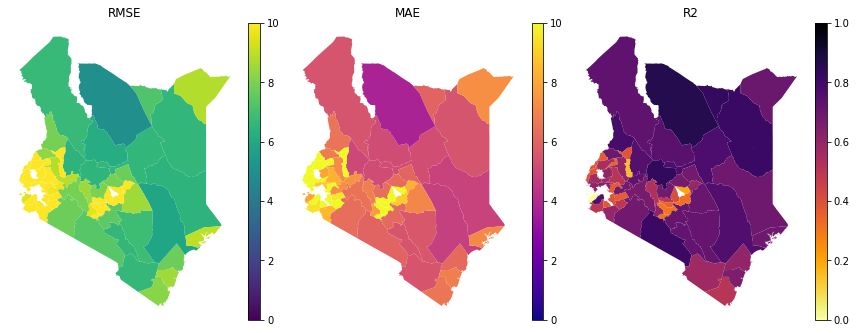

In [82]:
%autoreload 2
region_plotter.plot_all_regional_error_metrics(
    gdf.where(gdf.model == 'ealstm').dropna(),
    **dict(rmse_vmax=10, mae_vmax=10, mae_vmin=0, rmse_vmin=0)
);
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

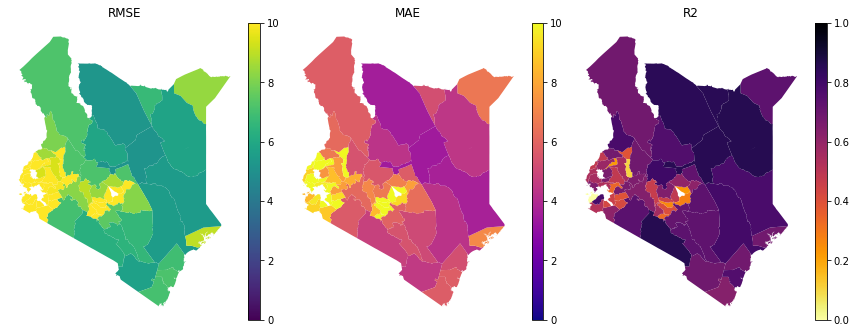

In [103]:
%autoreload 2
orig_region_plotter.plot_all_regional_error_metrics(
    orig_gdf.where(orig_gdf.model == 'ealstm').dropna(),
    **dict(rmse_vmax=10, mae_vmax=10, mae_vmin=0, rmse_vmin=0)
);
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

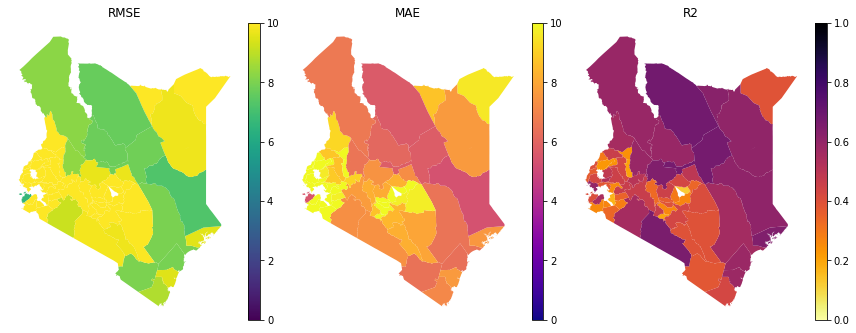

In [104]:
%autoreload 2
orig_region_plotter.plot_all_regional_error_metrics(
    orig_gdf.where(orig_gdf.model == 'previous_month').dropna(),
    **dict(rmse_vmax=10, mae_vmax=10, mae_vmin=0, rmse_vmin=0)
);
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

### Normalise by variance
- explore the patterns independent of how variable the VCI values are over time
- Controlling for how much the VCI changes, how do our spatial patterns of variability look?

In [105]:
# gdf.head()
variances = all_gdf.groupby('region_name').true_mean_value.std()
variances.head()

region_name
BARINGO    13.022800
BOMET      19.003933
BONDO      23.879618
BUNGOMA    20.467308
BURET      14.927562
Name: true_mean_value, dtype: float64

In [108]:
# # 
# gdf = gdf.drop(columns=['norm_rmse', 'norm_r2', 'norm_mae'])
gdf_norm = gdf.copy()
gdf_norm = gdf.rename(columns={'rmse': 'rmse_', 'r2': 'r2_', 'mae': 'mae_'})
gdf_norm['rmse'] = (gdf_norm.rmse_ / variances.loc[gdf.region_name].values) * gdf_norm.rmse_.mean()
gdf_norm['r2'] = (gdf_norm.r2_ / variances.loc[gdf.region_name].values) * gdf_norm.rmse_.mean()
gdf_norm['mae'] = (gdf_norm.mae_ / variances.loc[gdf.region_name].values) * gdf_norm.rmse_.mean()
gdf_norm.head(1)

# variances.loc[gdf.region_name].values

,model,admin_level_name,region_name,rmse_,mae_,r2_,DISTNAME,geometry,rmse,r2,mae
0,ealstm,district_l2_kenya,NAIROBI,16.416221,12.831153,0.309826,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...,10.175254,0.192039,7.953124


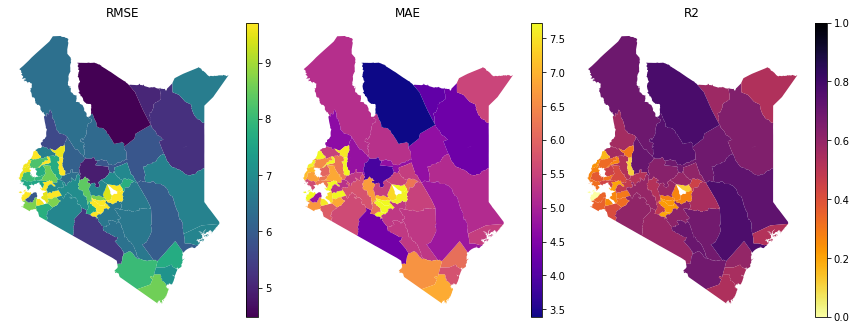

In [109]:
%autoreload 2
region_plotter.plot_all_regional_error_metrics(
    gdf_norm.where(gdf_norm.model == 'ealstm').dropna(),
#     **dict(rmse_vmax=10, mae_vmax=10, mae_vmin=0, rmse_vmin=0)
);
# plt.gcf().suptitle('RNN Regional Errors')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

## Explore Time series

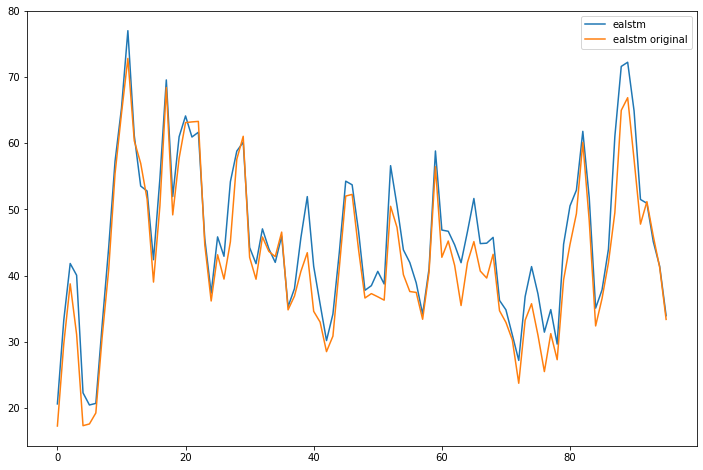

In [111]:
ealstm_ts = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'ealstm')].predicted_mean_value.rename('ealstm')
ealstm_bline_ts = orig_all_gdf.loc[(orig_all_gdf.region_name == region) & (orig_all_gdf.model == 'ealstm')].predicted_mean_value.rename('ealstm original')

fig, ax = plt.subplots(figsize=(12, 8))
ealstm_ts.reset_index().drop(columns='index').plot(ax=ax)
ealstm_bline_ts.reset_index().drop(columns='index').plot(ax=ax)

In [129]:
from typing import List

def plot_region_time_series(region: str, ax=None, model: List[str] = ['ealstm']):
    times = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'ealstm')].datetime 
    obs_ts = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'ealstm')].true_mean_value
#     rnn_ts = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'rnn')].predicted_mean_value
    ealstm_ts = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'ealstm')].predicted_mean_value
    
    # NON-predict delta functions
    ealstm_bline_ts = orig_all_gdf.loc[(orig_all_gdf.region_name == region) & (orig_all_gdf.model == 'ealstm')].predicted_mean_value
    rnn_ts = orig_all_gdf.loc[(orig_all_gdf.region_name == region) & (orig_all_gdf.model == 'rnn')].predicted_mean_value
    lr_ts = orig_all_gdf.loc[(orig_all_gdf.region_name == region) & (orig_all_gdf.model == 'linear_regression')].predicted_mean_value
    ln_ts = orig_all_gdf.loc[(orig_all_gdf.region_name == region) & (orig_all_gdf.model == 'linear_network')].predicted_mean_value
    bline_ts = orig_all_gdf.loc[(orig_all_gdf.region_name == region) & (orig_all_gdf.model == 'previous_month')].predicted_mean_value
    
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()
    df_dict = {'obs' : obs_ts.values}
    
    if 'lstm' in model:
        df_dict['lstm'] = rnn_ts.values
    if 'ealstm' in model:
        df_dict['ealstm'] = ealstm_ts.values
    if 'ealstm_bline' in model:
        df_dict['ealstm_bline'] = ealstm_bline_ts.values
    if 'lr' in model:
        df_dict['lr'] = lr_ts.values
    if 'ln' in model:
        df_dict['ln'] = ln_ts.values
    if 'baseline' in model:
        df_dict['baseline'] = bline_ts.values

    pd.DataFrame(df_dict, index=times).iloc[1:].plot(ax=ax)

    ax.set_ylim(0, 100)
    ax.set_title(f'{region} Predicted vs. Modelled');
    
    return fig, ax


def plot_region_seasonality(region, ax=None):
    ts = (
        all_df
        .loc[:, ['datetime', region]
        ].set_index('datetime')
    )
    
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()
    ts.groupby(ts.index.month).mean().plot(ax=ax)
    ax.set_title(f'Seasonal Cycle')
    ax.set_xlabel('Month')
    ax.set_ylabel('Mean NDVI');
    
    return fig, ax


def plot_region_vs_observed_seasonality(region, model, ax=None):
    ts = (
        all_gdf.loc[
            (all_gdf.model == model) & (all_gdf.region_name == region), 
            ['datetime', 'true_mean_value', 'predicted_mean_value']
        ].set_index('datetime')
    ).rename(
        columns={'true_mean_value': 'Observed', 'predicted_mean_value': f'Predicted ({model.upper()})'}
    )
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()
    
    ts.groupby(ts.index.month).mean().plot(ax=ax)
    ax.set_title(f'Seasonal Cycle for {region} District')
    ax.set_xlabel('Month')
    ax.set_ylabel('Mean VCI');

    return fig, ax

In [126]:
from sklearn.metrics import r2_score
from typing import Dict

from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

def rolling_average(district_csv: pd.DataFrame) -> Dict[str, float]:
    """Over three months"""
    relevant_districts = ['Mandera', 'Marsabit', 'Turkana', 'Wajir']

    district_csv['month'] = pd.to_datetime(district_csv.datetime).dt.month

    output_dict: Dict[str: float] = {}

    for district in relevant_districts:
        district_df = district_csv[district_csv.region_name == district.upper()]
        true, predicted = [], []
        for i in range(1, 12 - 1):
            min_month = i
            max_month = i + 3
            submonth = district_df[(district_df.month >= min_month) & (district_df.month < max_month)]
            predicted.append(submonth.predicted_mean_value.mean())
            true.append(submonth.true_mean_value.mean())
        district_score = r2(true, predicted)
        print(f'For {district}, r2 score: {district_score}')
        output_dict[district] = district_score
    
    return output_dict

In [118]:
print('Performance for EALSTM Predict Delta')
rolling_average(orig_all_gdf[orig_all_gdf.model == 'ealstm']);
print()

print('Performance for EALSTM Baseline')
rolling_average(all_gdf[all_gdf.model == 'ealstm']);
print()

print('Performance for Persistence')
rolling_average(orig_all_gdf[orig_all_gdf.model == 'previous_month']);
print()

print('Performance for RNN')
rolling_average(orig_all_gdf[orig_all_gdf.model == 'rnn']);
print()

Performance for EALSTM Predict Delta
For Mandera, r2 score: 0.9285030987864911
For Marsabit, r2 score: 0.9790304574600829
For Turkana, r2 score: 0.8505720902917523
For Wajir, r2 score: 0.9494434497738151

Performance for EALSTM Baseline
For Mandera, r2 score: 0.9190735851350883
For Marsabit, r2 score: 0.9195482293407499
For Turkana, r2 score: 0.5585825765387414
For Wajir, r2 score: 0.9681868729270298

Performance for Persistence
For Mandera, r2 score: 0.7418834628995075
For Marsabit, r2 score: 0.8156893342781715
For Turkana, r2 score: 0.6829170118607626
For Wajir, r2 score: 0.7708332053175011

Performance for RNN
For Mandera, r2 score: 0.8826001126667086
For Marsabit, r2 score: 0.9754361813286556
For Turkana, r2 score: 0.8224845706127023
For Wajir, r2 score: 0.9205917636033555



In [119]:
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2


model = 'ealstm'
region = 'TURKANA'

# TURKANA explore

def plot_region_performance(model: str, region: str, kind='reg'):
    df = pd.DataFrame(
        all_gdf.loc[
            (all_gdf.model == model) & (all_gdf.region_name == region),
            ['datetime', 'predicted_mean_value', 'true_mean_value']
        ].set_index('datetime')
    )

    # sns.scatterplot(x='true_mean_value', y='predicted_mean_value', data=turkana)
    # sns.lmplot(x='true_mean_value', y='predicted_mean_value', data=turkana)

    sns.jointplot(
        x='true_mean_value', y='predicted_mean_value', 
        data=df, kind=kind, stat_func=r2
    )
    
    ax = plt.gca()
    ax.set_xlabel(f'{region} - Observation')
    ax.set_ylabel(f'{region} - {model.upper()}');
    ax.set_xlim([0, 100])
    ax.set_ylim([0, 100])
    fig = plt.gcf()
    # fig.set_size_inches(11.7, 8.27)
    fig.set_size_inches(8.27, 8.27)

    return fig, ax


In [127]:
def highlight_selected_regions(regions: List[str], scale=1):
    fig, ax = plt.subplots(figsize=(12*scale, 8*scale))
    gdf = all_gdf.loc[(all_gdf.model=='ealstm') & (all_gdf.datetime == '2011-01-31')]
    gdf.plot(ax=ax, color='#23748d')
    for region in regions:

        gdf_ = gdf.loc[gdf.region_name == region]
        gdf_.plot(color='#57bfd0', ax=ax, alpha=0.9)

        gdf_.apply(
            lambda x: ax.annotate(
                s=x.region_name, xy=x.geometry.centroid.coords[0], ha='center'
            ), 
            axis=1
        );


        ax.set_axis_off()
#         fig.savefig(f'/Users/tommylees/Downloads/{region}_maps.png', transparent=True)
#         plt.close()



regions = ['MARSABIT', 'TURKANA', 'WAJIR', 'MANDERA', 'SAMBURU', 'ISIOLO', 'LAIKIPIA', 'MOYALE', 'KAJIADO']
regions = ['TURKANA', 'MANDERA', 'SAMBURU', 'GARISSA', 'MARSABIT', 'WAJIR', 'TANA RIVER', 'WEST POKOT','ISIOLO', 'KITUI', 'MOYALE']


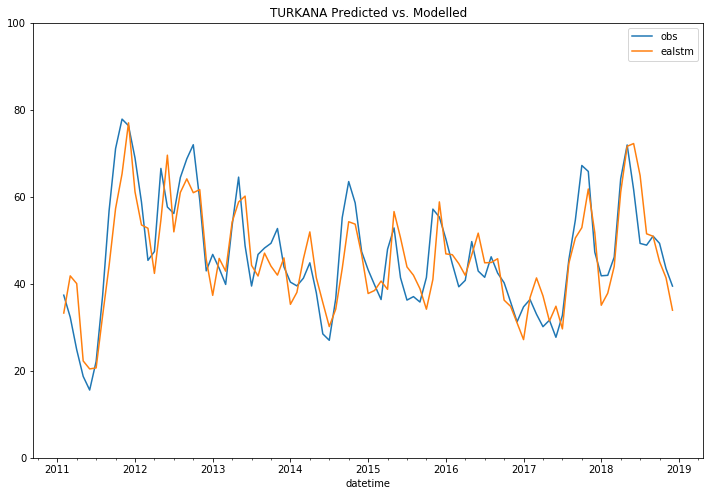

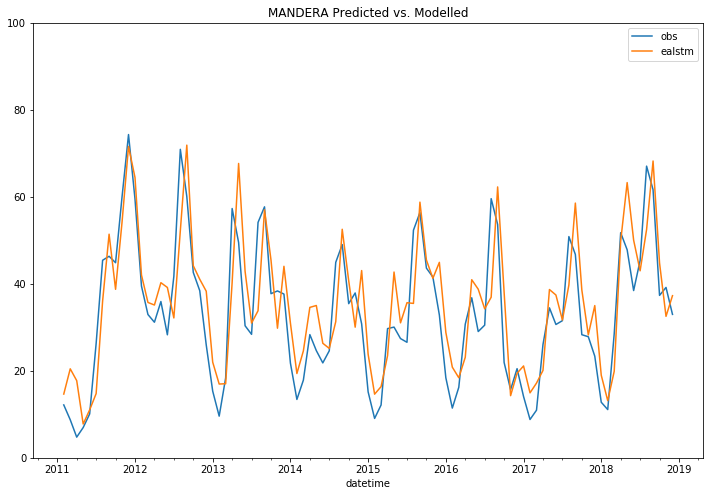

In [133]:
for region in regions[:2]:
    fig, ax = plt.subplots(figsize=(12,8))
#     plot_region_time_series(region=region, ax=ax, model=['ealstm', 'ealstm_bline']);
    plot_region_time_series(region=region, ax=ax, model=['ealstm']);
#     fig, ax = plot_region_performance(model='ealstm', region=region);
#     highlight_selected_regions([region])

# Event Hits/Misses

In [134]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes=None,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          **imshow_kwargs):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap, **imshow_kwargs)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
#            xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

### Quintiles of Vegetation Condition Index

In [152]:
def calculate_quintiles(da: xr.DataArray, new_variable_name: str = 'quintiles'):
    bins = [0.0, 20.0, 40.0, 60.0, 80.0]
    result = xr.apply_ufunc(np.digitize, da, bins)
    result = result.rename(new_variable_name)
    return result

mask = get_ds_mask(ds.VCI)
true_qs = calculate_quintiles(y_test.VCI).where(~mask)
pred_qs = calculate_quintiles(ealstm_pred.where(ealstm_pred > 0, 0).load()).where(~mask)
bline_qs = calculate_quintiles(bline_pred.load()).where(~mask)

Text(0.5, 1.0, 'How often do we predict the correct Quintiles?')

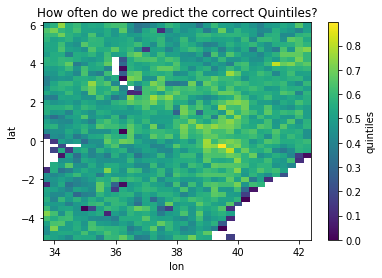

In [154]:
fig, ax = plt.subplots()
(pred_qs == true_qs).mean(dim='time').where(~mask).plot(ax=ax)
ax.set_title('How often do we predict the correct Quintiles?')


In [144]:
times = true_qs.time.values
true_np = true_qs.stack(pixel=['lat', 'lon']).values.flatten()
preds_np = pred_qs.stack(pixel=['lat', 'lon']).values.flatten()
bline_np = bline_qs.stack(pixel=['lat', 'lon']).values.flatten()

### test vegetation deficit index

In [151]:
from src.analysis import VegetationDeficitIndex

v = VegetationDeficitIndex(data_dir / 'interim/VCI_preprocessed/data_kenya.nc')
vdi_true = v.vegetation_index_classify(y_test.VCI, 'vdi')
vdi_ealstm_pred = v.vegetation_index_classify(ealstm_pred.load(), 'vdi')
vdi_ealstm_orig_pred = v.vegetation_index_classify(orig_ealstm_pred.load(), 'vdi')
vdi_bline = v.vegetation_index_classify(bline_pred.load(), 'vdi')

print(vdi_true.min(), vdi_true.max())

<xarray.DataArray 'vdi' ()>
array(1) <xarray.DataArray 'vdi' ()>
array(5)


In [153]:
test_da = y_test.VCI
test_da = ealstm_pred

# has it selected the right values? YES
print(f"VDI 1 mean: {test_da.where(vdi_true == 1).mean().values:.2f}")
print(f"VDI 2 mean: {test_da.where(vdi_true == 2).mean().values:.2f}")
print(f"VDI 3 mean: {test_da.where(vdi_true == 3).mean().values:.2f}")
print(f"VDI 4 mean: {test_da.where(vdi_true == 4).mean().values:.2f}")

VDI 1 mean: 15.25
VDI 2 mean: 23.35
VDI 3 mean: 33.51
VDI 4 mean: 44.65


In [145]:
# np.set_printoptions(precision=2)

# plot_confusion_matrix(true_np, preds_np, classes=None, normalize=True,
#                       title='EALSTM Normalized confusion matrix',
#                       **{'vmin': 0.05, 'vmax': 0.35})
# plot_confusion_matrix(true_np, bline_np, classes=None, normalize=True,
#                       title='BASELINE Normalized confusion matrix',
#                       **{'vmin': 0.05, 'vmax': 0.35})

In [146]:
ealstm_base_rmse.load().shape

(45, 35)

In [147]:
# ds.VCI.where(ds.VCI < 80).isnull().mean()
# y_test.VCI.where(y_test.VCI < 80).isnull().mean()
y_test.VCI.where(true_qs == 5).min() #.max() .median()
y_test.VCI.where(true_qs == 5).min()

<xarray.DataArray 'VCI' ()>
array(80.003748)

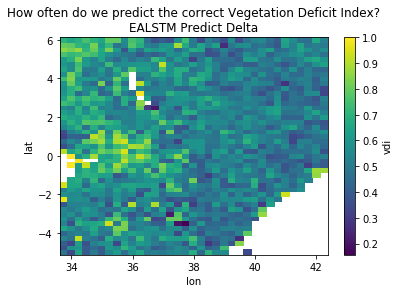

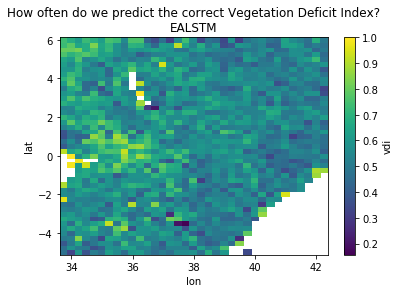

In [159]:
fig, ax = plt.subplots()
(vdi_ealstm_pred == vdi_true).mean(dim='time').where(~mask).plot(ax=ax)
ax.set_title('How often do we predict the correct Vegetation Deficit Index?\nEALSTM Predict Delta');

fig, ax = plt.subplots()
(vdi_ealstm_orig_pred == vdi_true).mean(dim='time').where(~mask).plot(ax=ax)
ax.set_title('How often do we predict the correct Vegetation Deficit Index?\nEALSTM');

# fig, ax = plt.subplots()
# (vdi_bline == vdi_true).mean(dim='time').where(~mask).plot(ax=ax)
# ax.set_title('How often do we predict the correct Vegetation Deficit Index?\nPersistence');

Red colours show that the Predictions are better than persistence. Blue show that persistence outperforms our models


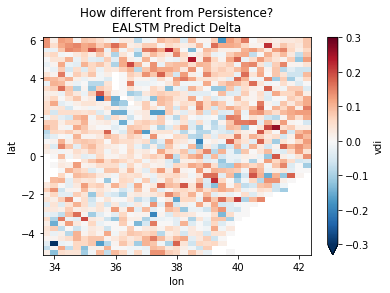

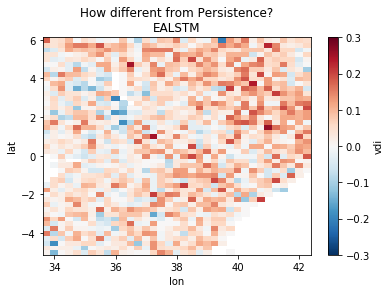

In [170]:
kwargs = {'vmin': -0.3, 'vmax':0.3, 'cmap': 'RdBu_r'}
# kwargs = {}

print('Red colours show that the Predictions are better than persistence. Blue show that persistence outperforms our models')

# how different from persistence?
fig, ax = plt.subplots()
((vdi_ealstm_pred == vdi_true).mean(dim='time') - (vdi_bline == vdi_true).mean(dim='time')).where(~mask).plot(ax=ax, **kwargs)
ax.set_title('How different from Persistence?\nEALSTM Predict Delta');

fig, ax = plt.subplots()
((vdi_ealstm_orig_pred == vdi_true).mean(dim='time') - (vdi_bline == vdi_true).mean(dim='time')).where(~mask).plot(ax=ax, **kwargs)
ax.set_title('How different from Persistence?\nEALSTM');



## Plot the Vegetation Deficit Index (VDI) from Klisch & Atzberger 2016

```python
dict(zip([0, 1, 2, 3, 4],[[0, 10], [10, 20], [20, 35], [35, 50], [50, 100]]))

```

`{0: [0, 10], 1: [10, 20], 2: [20, 35], 3: [35, 50], 4: [50, 100]}
`

Normalized confusion matrix
[[0.08066759 0.16324757 0.24956537 0.17863352 0.32788595]
 [0.05922643 0.13807989 0.26424542 0.17860021 0.35984805]
 [0.03451673 0.09007406 0.23796205 0.22362775 0.41381941]
 [0.02293152 0.06538581 0.20073684 0.24222704 0.4687188 ]
 [0.02653035 0.06842889 0.19035525 0.22916397 0.48552155]]
Normalized confusion matrix
[[0.12986787 0.17837274 0.2367872  0.15429416 0.30067803]
 [0.09439392 0.16265684 0.25100725 0.16173593 0.33020606]
 [0.05485809 0.11194101 0.25140641 0.20573372 0.37606077]
 [0.03708295 0.08239507 0.22635403 0.23668354 0.41748442]
 [0.0414294  0.08303675 0.21064126 0.22683448 0.43805811]]


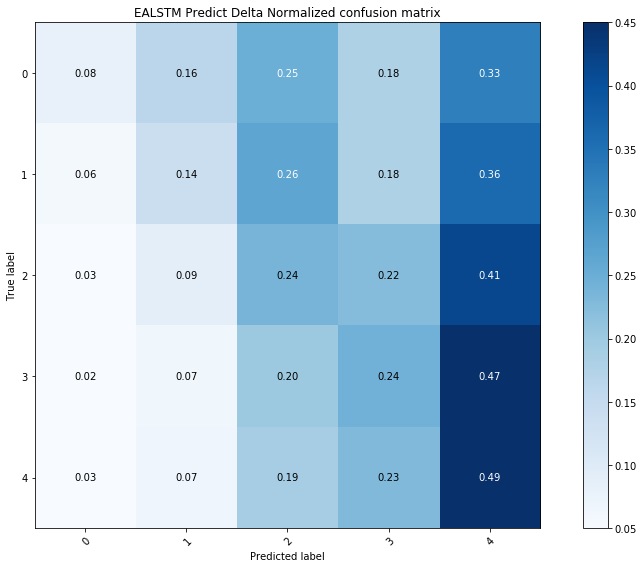

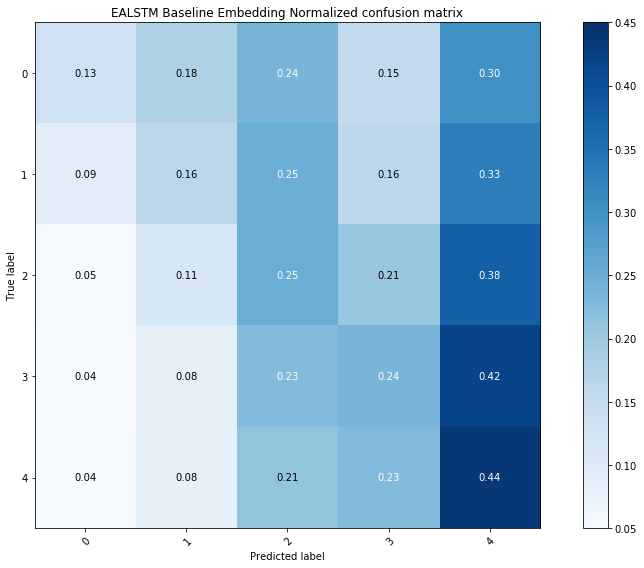

In [172]:
true_np = vdi_true.stack(pixel=['lat', 'lon']).values.flatten().clip(min=1, max=5)
preds_ealstm_np = vdi_ealstm_pred.stack(pixel=['lat', 'lon']).values.flatten().clip(min=1, max=5)
preds_ealstm_orig_np = vdi_ealstm_orig_pred.stack(pixel=['lat', 'lon']).values.flatten().clip(min=1, max=5)
bline_np = vdi_bline.stack(pixel=['lat', 'lon']).values.flatten()


plot_confusion_matrix(true_np, preds_ealstm_np.clip(min=1, max=5), classes=None, normalize=True,
                      title='EALSTM Predict Delta Normalized confusion matrix',
                      **{'vmin': 0.05, 'vmax': 0.45})

plot_confusion_matrix(true_np, preds_ealstm_orig_np.clip(min=1, max=5), classes=None, normalize=True,
                      title='EALSTM Baseline Embedding Normalized confusion matrix',
                      **{'vmin': 0.05, 'vmax': 0.45})